In [1]:
import pandas as pd
import torch
import os

# 수정된 로컬 모듈들을 임포트합니다.
from data_process import get_market_data
from env import MultiAssetPortfolioEnv
from agent import Agent
from evaluation import evaluate_agent
from utils import calculate_initial_weights # utils.py에 추가할 초기 가중치 계산 함수

try:
    torch.multiprocessing.set_start_method('fork', force=True)
except RuntimeError:
    pass

In [ ]:
# =================================================================================
# 1. 설정 (Configuration)
# =================================================================================

# --- 데이터 관련 파라미터 ---
TICKERS = [
    # 기술주
    "AAPL", "MSFT", "NVDA", "SMCI",
    # 통신 및 플랫폼
    "GOOGL", "META",
    # 소비재
    "AMZN", "TSLA", "COST", "KO",
    # 금융
    "JPM", "V",
    # 헬스케어
    "JNJ", "LLY",
    # 산업 및 에너지
    "CAT", "XOM",
    # ETF (시장, 섹터, 원자재, 채권)
    "SPY", "QQQ", "SOXX", "XLE", "GLD", "TLT", "SHY", "BIL",
    # 리츠
    "O"
]

START_DATE = "2015-01-01"
TRAIN_END_DATE = "2020-12-31"
VALIDATION_END_DATE = "2022-12-31"
TEST_END_DATE = "2024-12-31"

# --- 환경 관련 파라미터 ---
INITIAL_PORTFOLIO_VALUE = 1000000
TRANSACTION_COST_PCT = 0.001
RISK_AVERSION_COEFF = 0.01 # 기존 위험 회피 계수
HHI_PENALTY_COEFF = 0.1   # --- 추가된 부분: 분산투자 패널티 계수 ---

# --- 에이전트 및 훈련 관련 파라미터 (PPO용으로 변경) ---
RANDOM_SEED = 42
MAX_TRAINING_TIMESTEPS = 300000 # 총 훈련 타임스텝 수 (필요시 조절)
UPDATE_TIMESTEP = 2000          # 몇 타임스텝마다 정책을 업데이트할지
K_EPOCHS = 40                   # 한 번의 업데이트 시, 수집된 데이터를 몇 번 반복 학습할지
EPS_CLIP = 0.2                  # PPO 클리핑 계수
GAMMA = 0.99                    # 할인 계수

LR_ACTOR = 0.0003               # PPO용 Actor 학습률
LR_CRITIC = 0.001               # PPO용 Critic 학습률
ACTION_STD_INIT = 0.6           # 초기 탐색 표준편차

# --- 모델 저장 경로 ---
MODEL_SAVE_PATH = "./saved_models"
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

In [3]:
# =================================================================================
# 2. 데이터 준비 (Data Preparation)
# =================================================================================
print(f"\n[1/5] 📈 데이터 로딩 및 전처리 중... (기간: {START_DATE} ~ {TEST_END_DATE})")
full_data_df = get_market_data(
    tickers=TICKERS,
    start_date=START_DATE,
    end_date=TEST_END_DATE
)

# 훈련 데이터와 테스트 데이터 분리 (Lookahead Bias 방지)
train_df = full_data_df.loc[:TRAIN_END_DATE]
validation_df = full_data_df.loc[TRAIN_END_DATE:VALIDATION_END_DATE].iloc[1:]
test_df = full_data_df.loc[VALIDATION_END_DATE:].iloc[1:]
print(f"✅ 데이터 준비 완료: 훈련 {len(train_df)}일, 검증 {len(validation_df)}일, 테스트 {len(test_df)}일")


[1/5] 📈 데이터 로딩 및 전처리 중... (기간: 2015-01-01 ~ 2024-12-31)


[******                12%                       ]  3 of 25 completed

[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  25 of 25 completed
/workspaces/Deep-RL-for-Portfolio-Optimization/data_process.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adj_close_data.fillna(method='ffill', inplace=True)
/workspaces/Deep-RL-for-Portfolio-Optimization/data_process.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_close_data.fillna(method='ffill', inplace=True)
/workspaces/Deep-RL-for-Portfolio-Optimization/data_process.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adj_close_data.fillna(method='bfill', inplac

✅ 데이터 준비 완료: 훈련 1452일, 검증 503일, 테스트 500일


In [4]:
# =================================================================================
# 3. 환경 및 에이전트 생성 (Instantiation)
# =================================================================================
print("\n[2/5] 🛠️  환경 및 에이전트 생성 중...")

initial_weights = calculate_initial_weights(assets=TICKERS, method='equal')

# 훈련 환경 생성
train_env = MultiAssetPortfolioEnv(
    df=train_df, assets=TICKERS, initial_weights=initial_weights,
    initial_portfolio_value=INITIAL_PORTFOLIO_VALUE,
    transaction_cost_pct=TRANSACTION_COST_PCT, 
    risk_aversion_coeff=RISK_AVERSION_COEFF,
    hhi_penalty_coeff=HHI_PENALTY_COEFF # 추가
)

# 검증 환경 생성
validation_env = MultiAssetPortfolioEnv(
    df=validation_df, assets=TICKERS, initial_weights=initial_weights,
    initial_portfolio_value=INITIAL_PORTFOLIO_VALUE,
    transaction_cost_pct=TRANSACTION_COST_PCT,
    risk_aversion_coeff=RISK_AVERSION_COEFF,
    hhi_penalty_coeff=HHI_PENALTY_COEFF # 추가
)

# 테스트 환경 생성
test_env = MultiAssetPortfolioEnv(
    df=test_df, assets=TICKERS, initial_weights=initial_weights,
    initial_portfolio_value=INITIAL_PORTFOLIO_VALUE,
    transaction_cost_pct=TRANSACTION_COST_PCT,
    risk_aversion_coeff=RISK_AVERSION_COEFF,
    hhi_penalty_coeff=HHI_PENALTY_COEFF # 추가
)

# 환경으로부터 state 및 action 크기 확보
state_size = train_env.observation_space.shape[0]
action_size = train_env.action_space.shape[0]

# --- PPO 에이전트 생성 ---
agent = Agent(
    state_dim=state_size, 
    action_dim=action_size, 
    lr_actor=LR_ACTOR, 
    lr_critic=LR_CRITIC, 
    gamma=GAMMA, 
    K_epochs=K_EPOCHS, 
    eps_clip=EPS_CLIP,
    action_std_init=ACTION_STD_INIT
)
print(f"✅ PPO 에이전트 생성 완료: State Size={state_size}, Action Size={action_size}")


[2/5] 🛠️  환경 및 에이전트 생성 중...
✅ PPO 에이전트 생성 완료: State Size=4826, Action Size=26


In [5]:
# =================================================================================
# 4. 모델 훈련 (Training)
# =================================================================================
print(f"\n[3/5] 🧠 모델 훈련 시작... (총 {MAX_TRAINING_TIMESTEPS} 타임스텝)")
agent.train(
    train_env=train_env,
    validation_env=validation_env,
    max_training_timesteps=MAX_TRAINING_TIMESTEPS,
    update_timestep=UPDATE_TIMESTEP,
    model_path=MODEL_SAVE_PATH
)
print("\n✅ 모델 훈련 완료.")



[3/5] 🧠 모델 훈련 시작... (총 300000 타임스텝)


Training Timesteps (PPO):   3%|▎         | 10045/300000 [01:48<9:18:10,  8.66it/s] 


Timestep 10000	Validation Sharpe Ratio: -0.3708
🎉 New best model found! Saving model to ./saved_models


Training Timesteps (PPO):   7%|▋         | 20031/300000 [03:35<8:23:39,  9.26it/s] 


Timestep 20000	Validation Sharpe Ratio: -0.5076


Training Timesteps (PPO):   8%|▊         | 23977/300000 [04:03<15:17, 300.91it/s]  

KeyboardInterrupt: 


[4/5] 📊 최적 모델 로드 및 최종 평가 시작 (Out-of-Sample Backtest)...
✅ 최적 모델 가중치를 성공적으로 로드했습니다.
--- Running Backtest for PPO Agent ---



--- Running Backtest for Equal Weight Benchmark ---

               PERFORMANCE SUMMARY
             CAGR Annualized Volatility Sharpe Ratio Max Drawdown (MDD)
PPO Agent  30.14%                18.13%         1.66            -12.78%
Benchmark  28.97%                13.30%         2.18             -9.50%



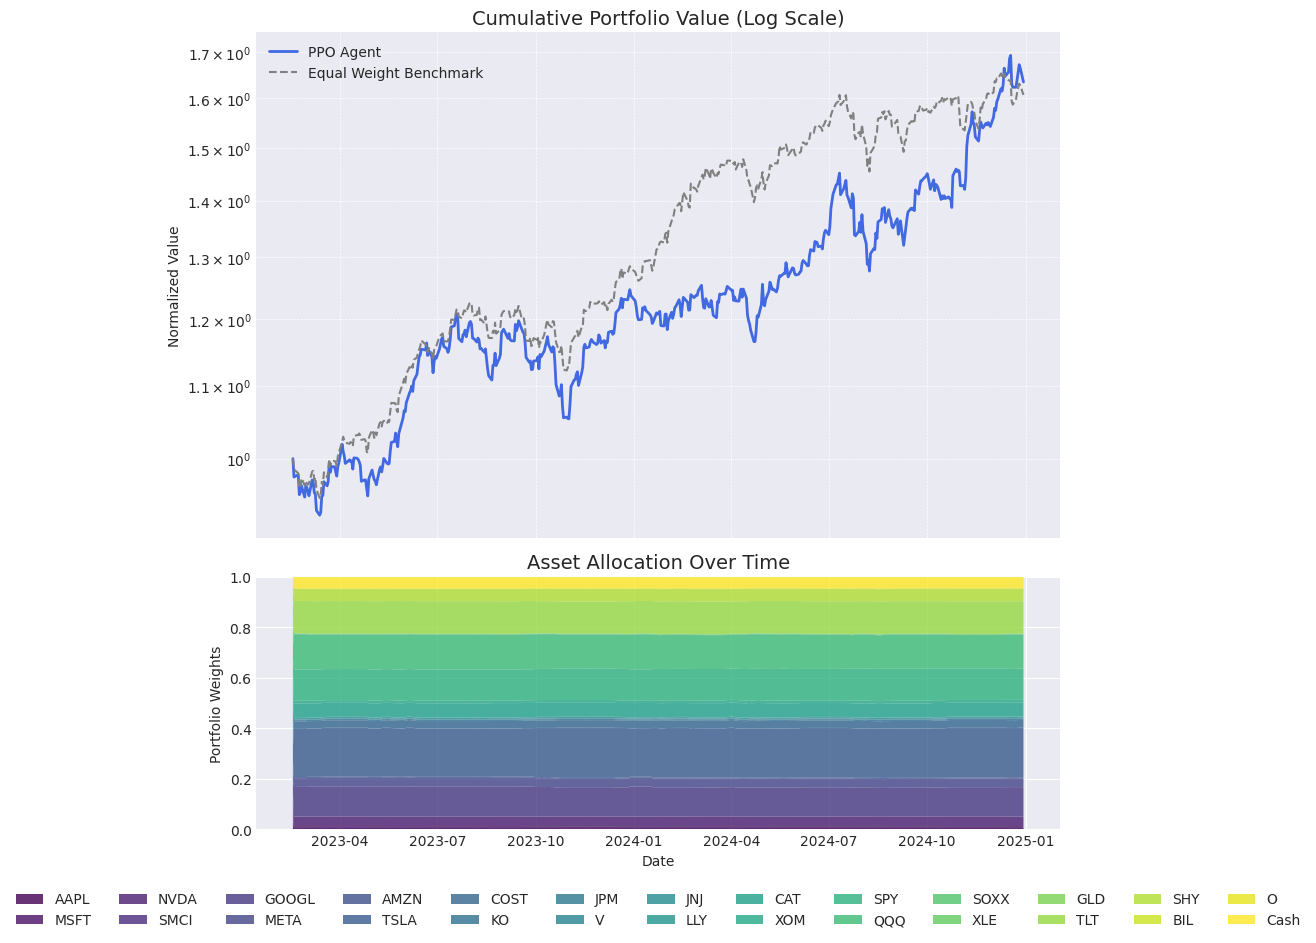


[5/5] ✅ 평가 및 시각화 완료.


Training Timesteps (PPO):   8%|▊         | 24000/300000 [04:20<15:17, 300.91it/s]

In [ ]:
# --- 저장된 최적 PPO 모델 가중치 로드 ---
print("\n[4/5] 📊 최적 모델 로드 및 최종 평가 시작 (Out-of-Sample Backtest)...")
try:
    agent.policy.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, 'best_ppo_model.pth')))
    print("✅ 최적 모델 가중치를 성공적으로 로드했습니다.")
except FileNotFoundError:
    print("⚠️ 저장된 최적 모델을 찾을 수 없습니다. 마지막 시점의 모델로 평가합니다.")

# --- 평가 함수 호출 (PPO 에이전트 이름으로 변경) ---
from evaluation import evaluate_agent
evaluate_agent(env=test_env, agent=agent)
print("\n[5/5] ✅ 평가 및 시각화 완료.")